In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

lenLat =  1118.033988749895
dx, dk, spec  1.0918300671385692 0.00561985178483258 513
4.691979400210538
1.5912059069690707


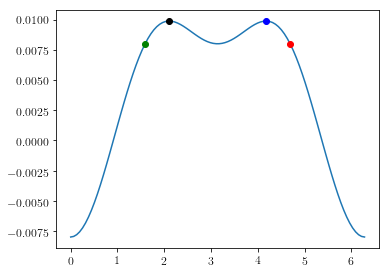

In [3]:
nLat = 1024
fSim = 0
nSims = 1000

filter_size = 0.
phi0 = 2.3
lamb = 1.4
nCols = 2

nu = 2.*10**(-3)
V0 = 4.*nu
m2eff = lambda lam: V0 * (- 1. + lam**2)
lenLat = 100. / np.sqrt(V0); print('lenLat = ', lenLat)
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)

V = lambda phi, lamb: V0 * (-np.cos(phi)+0.5*lamb**2.*np.sin(phi)**2.)
dV = lambda phi, lamb: V0 * (np.sin(phi)+0.5*lamb**2.*np.sin(2.*phi))

right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[0, np.pi], method='bounded')
phi_upper_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 5)[0]; print(phi_upper_bound)
phi_lower_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 1)[0]; print(phi_lower_bound)
plt.plot(np.linspace(0, 2*np.pi, 100), V(np.linspace(0, 2*np.pi, 100), lamb))
plt.plot(phi_upper_bound, V(phi_upper_bound, lamb), 'ro', phi_lower_bound, V(phi_lower_bound, lamb), 'go')
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x, lamb), 'bo', left_phi_at_V_max.x, V(left_phi_at_V_max.x, lamb), 'ko')

### Theoretical Field PS 

In [4]:
# field spectrum
norm = lambda phi: 1./ phi / np.sqrt(lenLat)
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
omega = lambda m2: np.sqrt(freqs**2. + m2)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, m2, tem: norm(phi) * np.sqrt(2./(np.exp(omega(m2)/tem) - 1.)) / np.sqrt(2.*omega(m2))
pspec = lambda phi, m2, tem, sigma: np.abs(spectral_field(phi, m2, tem) * Filter(sigma))**2.
sigma0_th = lambda phi, m2, tem, sigma: np.sqrt(np.sum(pspec(phi, m2, tem, sigma)))

In [5]:
max(freqs)

2.8717442620494484

### Extract data from files

In [6]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
#pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'
pickle_file = '/gpfs/dpirvu/thermal_bubbles/'

sim_location = lambda nL, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, tem: '_for_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)
bubbles_file = lambda phi, lam, tem, lSim, mSim: pickle_file+'bubbles_from_sim'+str(lSim)+'_up_to'+str(mSim)+sim_suffix(phi, lam, tem)+'.npy'

In [7]:
def direct_import_sim(nL, tem, phi, lam, sim, lSim, mSim, filter=0.):
    all_rsp_data = []
    for sim in range(lSim, mSim):
#        if sim == (mSim-lSim) // 2: print('Halfway through.')
        loc = sim_location(nL, tem, phi, lam, sim)
        simulation = [[]]*nCols
        if os.path.exists(loc):
            data = np.genfromtxt(loc)
            nT = len(data[:,1])//nL
            for col in range(nCols):
                simulation[col] = np.reshape(data[:,col], (nT, nL))
            if filter != 0:
                for col in range(nCols):
                    simulation[col] = np.asarray([gaussian_filter1d(slic, filter) for slic in simulation[col]])
            all_rsp_data.append(simulation)
    return np.asarray(all_rsp_data)
    
def extract_sim(nL, tem, phi, lam, sim, filter=0.):
    loc = sim_location(nL, tem, phi, lam, sim)
    simulation = [[]]*nCols
    if os.path.exists(loc):
        data = np.genfromtxt(loc)
        nT = len(data[:,1])//nL
        print(loc)
        print(nT)
        if nT < 10000:
            for col in range(nCols):
                simulation[col] = np.reshape(data[:,col], (nT, nL))
            if filter != 0:
                for col in range(nCols):
                    simulation[col] = np.asarray([gaussian_filter1d(slic, filter) for slic in simulation[col]])
            return simulation, nT
        else:
            return None, None
    else:
#        print('File not found.')
        return None, None

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

def check_decay(data):
    field = data[0]
    nL = len(field[0])
    right_phi = sum([1 for x in field[-1] if x > np.floor(phi_upper_bound)])
    left_phi = sum([1 for x in field[-1] if x < np.ceil(phi_lower_bound)])
    if right_phi > nL*0.05 and left_phi < nL*0.05: return 0 # and right_phi < nL*0.4 and left_phi < nL*0.05: return 0
    elif left_phi > nL*0.05 and right_phi < nL*0.05: return 1 # and left_phi < nL*0.4 and right_phi < nL*0.05: return 1
    else: return 2

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)

def time_at_size(bubble, size, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= size) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), T-1)


def triage(nL, tem, phi, lam, sim, filter):
    data, nT = extract_sim(nL, tem, phi, lam, sim, filter)
    tmin = 1000
    if nT is not None and nT > tmin:
        outcome = check_decay(data)
        if outcome != 2:
            if outcome == 1:
                data[0] = [2*phi_initial - i for i in data[0]]
                data[1] = [-i for i in data[1]]
            tmax = time_at_size(data[0], 1, 3*np.pi)
            print('tmax', tmax)
            tdecap = time_at_fraction(data[0], 0.01, phi_upper_bound) - 1000
            if tdecap < 0: tdecap = 0
            for column in data:
                column = column[tdecap:tmax:]
#            print('sim', sim, ', duration ', nT)
            return data, sim

def alldata(nL, tem, phi, lam, filter, lSim, mSim):
    all_rsp_data, sims_to_keep = [], []
    for sim in range(lSim, mSim):
#        if sim == (mSim-lSim) // 2: print('Halfway through.')
        a = triage(nL, tem, phi, lam, sim, filter)
        if a is not None:
            data, sim = a
            all_rsp_data.append(data)
            sims_to_keep.append(sim)
    return all_rsp_data, sims_to_keep

In [8]:
# find /gpfs/dpirvu/thermal_bubbles/ -name "*.dat" -type 'f' -size 264M -delete
# find /gpfs/dpirvu/thermal_bubbles/clean_* -name "*.dat" -type 'f' -size +1054M -delete

In [9]:
list_temp = [0., 0.1, 0.2]

split_sims = np.arange(fSim, nSims+1, 100); print(split_sims)
for temp in list_temp:
    print('At T = ', temp)
    for lSim, mSim in zip(split_sims, split_sims[1:]):
        print(lSim, mSim)
        all_data, sims_to_keep = alldata(nLat, temp, phi0, lamb, filter_size, lSim, mSim)
        if len(sims_to_keep) > 0:
            print('giving ', len(sims_to_keep), ' good bubbles.')
            np.save(bubbles_file(phi0, lamb, temp, lSim, mSim), [all_data, sims_to_keep])

#all_data = direct_import_sim(nLat, temp, phi0, lamb, fSim, nSims, filter_size)

#print(np.shape(all_data))

[ 200  300  400  500  600  700  800  900 1000]
At T =  0.0
200 300
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim201_fields.dat
8628
tmax 8438
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim202_fields.dat
3818
tmax 3629
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim203_fields.dat
9136
tmax 8947
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim207_fields.dat
4954
tmax 4759
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim209_fields.dat
6383
tmax 6191
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim217_fields.dat
2578
tmax 2572
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim219_fields.dat
10155
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim221_fields.dat
4208
tmax 4017
/gpfs/dpirvu/thermal_b

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


300 400
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim300_fields.dat
2088
tmax 1902
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim302_fields.dat
6975
tmax 6789
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim304_fields.dat
6964
tmax 6774
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim314_fields.dat
4203
tmax 4013
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim316_fields.dat
7494
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim320_fields.dat
10228
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim322_fields.dat
2060
tmax 1869
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim324_fields.dat
5710
tmax 5521
/gpfs/dpirvu/thermal_bubbles/clean_bubbles_x1024_temp0.0000_phi02.3000_lamb1.4000_sim328_fi

In [10]:
def plot_real_space_data(sim, col):
    simulation = all_data[sim][col]
    T, N = np.shape(simulation)
    fig, ax0 = plt.subplots(1, 1, figsize = (10,5))
    im0 = ax0.imshow(simulation, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax0); clb.set_label(r'$\phi(x)$', labelpad=-48, y=1.08, rotation=0)
    ax0.set(xlabel = r'$x$', ylabel = r'$t$')#; ax1.set(xlabel = r'$x$', ylabel = r'$t$')
    plt.show()
    return

def plot_real_space_slice(sim, timeslice):
    slice = all_data[sim][col][timeslice]
    plt.figure(figsize = (50, 3))
    plt.plot(np.arange(len(slice)), slice, label=timeslice)
    labelLines(plt.gca().get_lines(), xvals=(0, nLat//2), align=False)
    plt.xlabel(r'$x$'); plt.ylabel(r'$\phi(x)$'); plt.legend(); plt.show()
    return

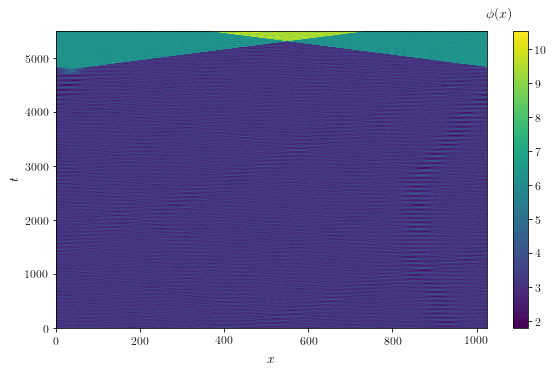

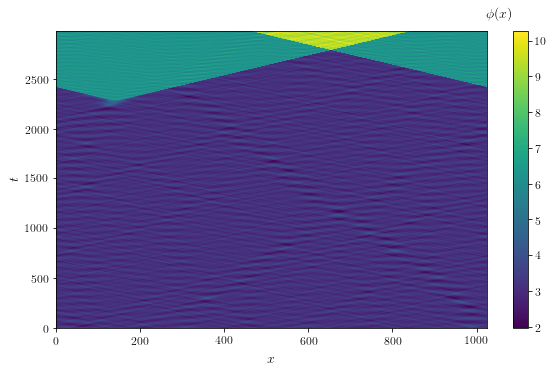

In [11]:
col = 0 
for sim in range(len(all_data))[::]:
    plot_real_space_data(sim, col)

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


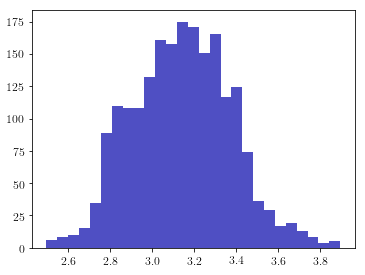

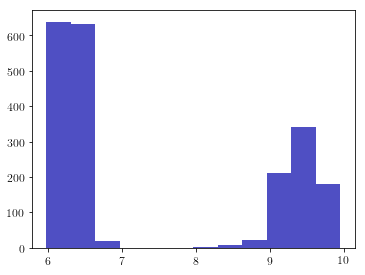

In [12]:
all_data = np.asarray(all_data)
for timeslice in [0, -1]:
    slic = [item for sublist in [all_data[sim][col][timeslice] for sim in range(len(all_data))] for item in sublist]
    hist, bin_edges = np.histogram(slic)
    fig = plt.figure()
    n, bins, patches = plt.hist(x=slic, bins='auto', color='#0504aa', alpha=0.7, rwidth=1)
    plt.show()